# PROJECT TITLE: IMAGE BASED SPORTS CLASSIFICATION USING PRE TRAINED MODELS AND TRANSFER LEARNING

**OBJECTIVE**

The objective of this project is to build an accurate deep learning model capable of classifying images into 100 different sports categories.

**DATASET SUMMARY**

- The dataset used in this project is a curated collection of 10,000+ images across 100 different sports categories. Each category contains 100 images showcasing a wide variety of sports such as cricket, football, baseball, volleyball, motorcycle racing, tennis, and lesser-known activities like pole dancing, log rolling, and chuckwagon racing.

- The images are balanced across classes, ensuring equal representation, which is ideal for training deep learning models without bias.

- Each image is labeled with its corresponding sport, making the dataset suitable for supervised multi-class image classification. The data was preprocessed to standardize input dimensions and normalize pixel values. Due to the diversity of the sports and visual features, the dataset presents a challenging but interesting classification task.

- Images are stored in train, validation and test for each sports categories separatly in drive.

IMPORTING NECESSARY LIBRARIES

In [11]:
# Importing necessary libraries
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0


DEFINING THE PATH FOR DIRECTORY

In [12]:
# Define the path of the directory
base_dir = '/content/drive/MyDrive/Capstone project 2- Sports image classification using transfer learning/Capstone project 2 - Sports image classification'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')


Now we have created each directories path. From there we need to bring the images. Next we need to check the images that are loaded correctly.

CHECK AND LOAD THE IMAGES

In [ ]:
# We need to write a function to load and visualise the images using matplotlib.

def plot_images_from_folder(folder, num_images=5):   # folder- the directory where images stored, num_images- no.of images to display, here 5.
  images = os.listdir(folder)[:num_images]           # Retrives a list of all files in a folder and slices the first 5 images
  plt.figure(figsize= (15,5))                           # plot the images with 15 x 5.

  for i, img_name in enumerate(images):              # enumerate- iterate over all the images by giving index and image name
    img = plt.imread(os.path.join(folder, img_name)) # construct full file path for each image and read the image
    plt.subplot(1, num_images, i+1)                  # Creates a subplot in a 1-row grid with num_images columns, placing the current image in the i + 1 position
    plt.imshow(img)                                  # Display the image
    plt.axis('off')                                  # To view the clean image without any axis
  plt.show()                                         # Display images


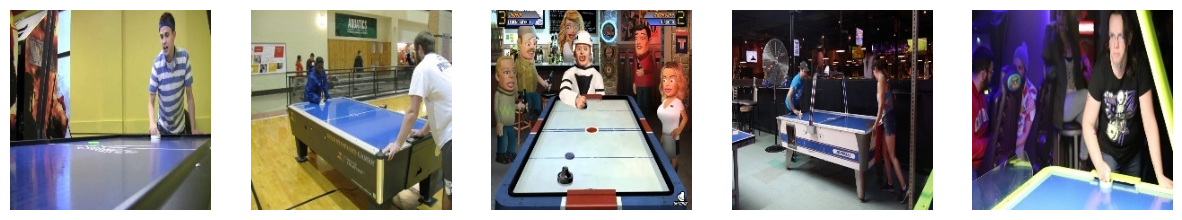

In [ ]:
# Checking the images from train directory

plot_images_from_folder(os.path.join(train_dir,'air hockey'))

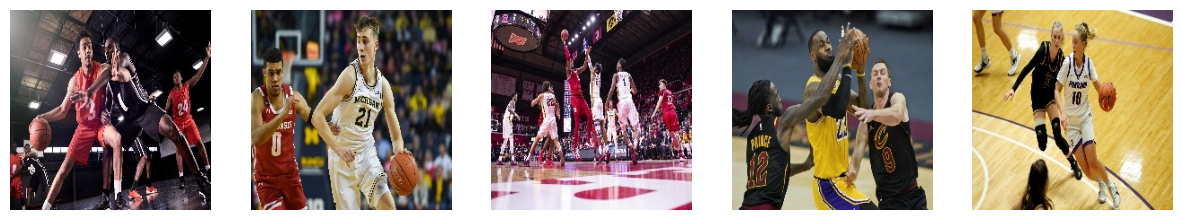

In [ ]:
# Checking the images from validation directory

plot_images_from_folder(os.path.join(validation_dir, 'basketball'))

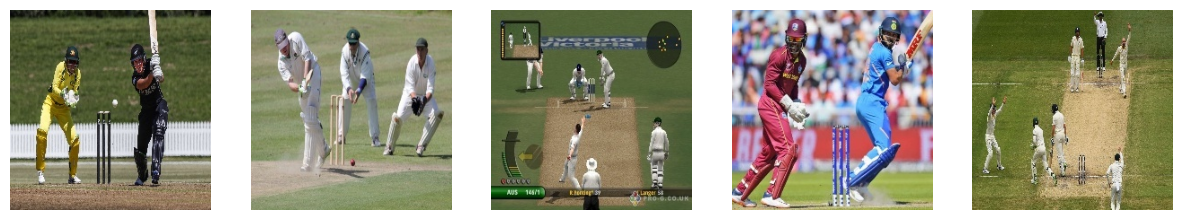

In [ ]:
# Checking the images from test directory

plot_images_from_folder(os.path.join(test_dir, 'cricket'))

DATA PREPROCESSING AND AUGMENTATION

In [ ]:
# Data augumentaion using ImageDataGenerator

train_datagen= ImageDataGenerator(
    rescale = 1./255,            # Using keras utility, augment the image, normalize pixel value from (0,255) to (0,1) by pixel values
    rotation_range= 20,         # Rotate image by 20 deg
    height_shift_range= 0.2,    # shift height by 20%
    width_shift_range= 0.2,     # shift width by 20%
    shear_range= 0.2,           # shear the image by 20%
    zoom_range= 0.2,            # Zooming the image by 20%
    fill_mode ='nearest'        # fill the newly created pixel value using nearest pixel values
)

validation_datagen= ImageDataGenerator( rescale= 1./255)   # Validation data shouldn't be augmented, only normalization and evaluation is on original images.

test_datagen= ImageDataGenerator(rescale=1./255)           # Test data shouldn't be augmented

In [ ]:
# Creating data generator

train_generator = train_datagen.flow_from_directory(
    train_dir,                      # Load images from and path to the train_dir where train images stored.
    target_size = (224, 224),       # Resize the images to 224 x 224 suitable for VGG16 model and Resnet50
    batch_size= 32,                 # batch of 32 images are train generator
    class_mode= 'categorical')      # labels are one hot encoded, categorical for multiclass classification

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode = 'categorical')

test_generator= test_datagen.flow_from_directory(
    test_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'categorical',
    shuffle= False
)

Found 13522 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


MODEL TRAINING WITH PRE-TRAINED MODELS

# **VGG16**

In [ ]:
# First we use the base model and some changes with final layer

base_model_VGG16= VGG16(
    input_shape= (224,224,3),    # shape of our image
    include_top= False,          # leave out the final fully connected layer to customize
    weights= 'imagenet'          # weights added with imagenet
)

# we don't have to train all the layers and make them non trainable

base_model_VGG16.trainable= False

# Let build the last full connected layer

model_VGG16 = Sequential([
              base_model_VGG16,
              Flatten(),          # convert to base model multi dimensional tensor to 1 D vector.
              Dense(254, activation='relu'),  # fully connected layer with 254 neurons and relu activation to introduce non linearity for model to learn complex pattern
              Dense(128, activation='relu'), # To add more complexity
              Dropout(0.2),                   # Regularization to avoid overfitting by 20%.
              Dense(len(train_generator.class_indices), activation= 'softmax')
              ])   # Final output layer, determines the number of output classes based on the training data.



model_VGG16.compile(optimizer= RMSprop(learning_rate=0.0001),       # Using RMSprop optimizer for faster training
                    loss='categorical_crossentropy',  # the loss function to be used during training. For multiclass classification and target labels one hot encoded
                    metrics= ['accuracy'])      # Evaluate model performance


# # Training the model

VGG_history= model_VGG16.fit(train_generator,
                             validation_data= validation_generator,
                             epochs= 10,
                             callbacks= [EarlyStopping(monitor='val_loss', patience=3 )])  # If the validation loss does not improve for 3 consecutive epochs, training will stop early


Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 235s 548ms/step - accuracy: 0.0365 - loss: 4.4750 - val_accuracy: 0.2480 - val_loss: 3.5228
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 230s 543ms/step - accuracy: 0.1643 - loss: 3.6718 - val_accuracy: 0.4040 - val_loss: 2.6298
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 222s 524ms/step - accuracy: 0.2751 - loss: 3.0665 - val_accuracy: 0.5460 - val_loss: 2.0252
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 229s 542ms/step - accuracy: 0.3493 - loss: 2.6511 - val_accuracy: 0.5900 - val_loss: 1.6522
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 231s 547ms/step - accuracy: 0.3972 - loss: 2.3744 - val_accuracy: 0.6400 - val_loss: 1.4199
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 225s 531ms/step - accuracy: 0.4503 - loss: 2.1712 - val_accuracy: 0.6700 - val_loss: 1.2947
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 227s 535ms/step - accuracy: 0.4715 - loss: 1.9851 - val_accuracy: 0.6760 - val_loss: 1.1389
Epoch 8/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 220s 521ms/step - accuracy: 0.5094 -

OBSERVATION

- Training accuray is 54% and validation acccuracy is 74% and it still improving and outpace training accuracy. The model is learning relavant, generalizing the data.

- No sign of overfitting since val_loss continues to decrease, early stopping is not triggered, the model was still improving.


Let check the accuracy as well.

EVALUATION ON TEST SET

In [ ]:
loss, accuracy = model_VGG16.evaluate(test_generator)

print(loss, accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 192s 13s/step - accuracy: 0.7689 - loss: 0.8915
0.8608871102333069 0.7739999890327454


- Test accuracy is 76% and test loss is 0.89. An accuracy of 76% on the test set is a strong result and with the 100 classes. The model generalised the unseen data.

- Test loss(0.891) is also lower compare to training loss(1.684), the model is effectively learning the relavant features and not overfitting.

CONFUSION MATRIX AND CLASSIFICATION REPORT

*CLASSIFICATION REPORT*

In [ ]:
# Predict on test data

Y_pred = model_VGG16.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.60      0.75         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       0.33      0.20      0.25         5
           8       0.40      0.40      0.40         5
           9       1.00      0.40      0.57         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       0.67      0.40      0.50         5
          14       0.00      0.00      0.00         5
          15       0.80      0.80      0.80         5
          16       0.83      1.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


*OBSERVATION*

- Macro avg F1 score 75% indicates balanced performance across classes.

- Weighted avg F1 score 75% indicates the model performs well.

- Some classes scored perfectly 1.00 and some performed poorly 0.00. High
  variance across classes.

- Low recall/precision in some classes, never predicted those classes.

*CONFUSION MATRIX*

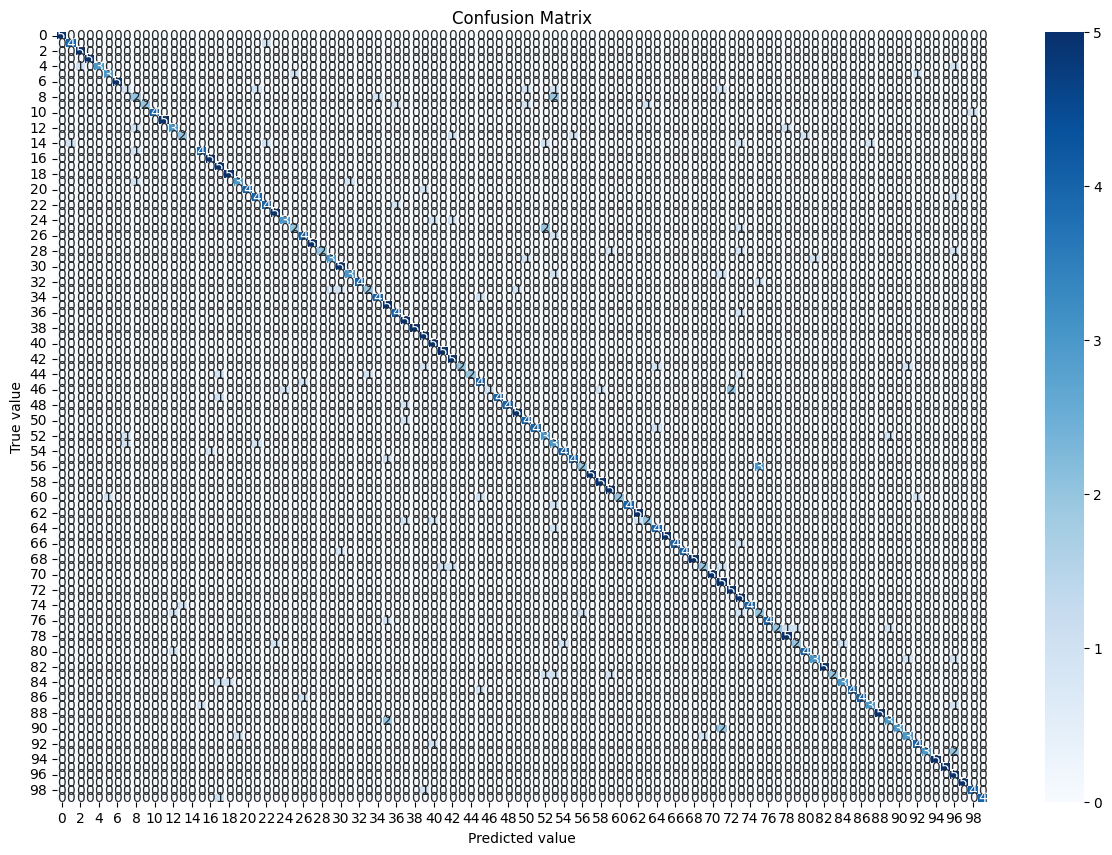

In [ ]:
# Visulize confusion matrix

cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(15,10))
sns.heatmap(cm, cmap='Blues', annot= True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.show()

*OBSERVATION*

- The matrix is heavily diagonal dominant which is a good sign. Most  
  predictions aligns with true labels.
- Some observations are non diagonal and there are occasional misclassifications.

Lets try with other pre-trained model.

**INCEPTION**

In [ ]:
# create a Data generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (150,150),
    batch_size= 32,
    class_mode = 'categorical'
)

validation_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size= (150,150),
    batch_size= 32,
    class_mode = 'categorical'
)

test_generator= test_datagen.flow_from_directory(
    test_dir,
    target_size= (150,150),
    batch_size= 32,
    class_mode = 'categorical'
)

Found 13522 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
# Model training with inception pre-trained model

base_model_inception = InceptionV3(
    input_shape = (150,150,3),
    include_top= False,
    weights='imagenet'
 )


# Base model non trainable

base_model_inception.trainable= False

# Build last full connected layer

model_inception = Sequential([
    base_model_inception,
    Flatten(),
    Dense(1024, activation= 'relu'),
    Dropout(0.2),
    Dense(len(train_generator.class_indices), activation= 'softmax')
    ])

model_inception.compile(
    optimizer= Adam(),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

# Training the model

inception_history= model_inception.fit(
    train_generator,
    validation_data= validation_generator,
    epochs= 10,
    callbacks = [EarlyStopping(monitor= 'val_loss', patience=3)]
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 7402s 17s/step - accuracy: 0.0847 - loss: 8.3354 - val_accuracy: 0.2700 - val_loss: 2.8558
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 132s 294ms/step - accuracy: 0.2186 - loss: 3.2500 - val_accuracy: 0.3580 - val_loss: 2.2918
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 145s 300ms/step - accuracy: 0.2660 - loss: 2.8939 - val_accuracy: 0.4140 - val_loss: 2.0259
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 126s 298ms/step - accuracy: 0.2769 - loss: 2.7920 - val_accuracy: 0.4460 - val_loss: 1.9105
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 124s 293ms/step - accuracy: 0.3117 - loss: 2.6509 - val_accuracy: 0.4540 - val_loss: 1.8791
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 127s 300ms/step - accuracy: 0.3298 - loss: 2.5936 - val_accuracy: 0.4740 - val_loss: 1.7311
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 142s 299ms/step - accuracy: 0.3336 - loss: 2.5090 - val_accuracy: 0.4700 - val_loss: 1.7627
Epoch 8/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 127s 300ms/step - accuracy: 0.3324 - 

*OBSERVATION*

- Training accuracy is 34% and validation acccuracy is 50% which is average and validation accuracy improves steadily and higher than training accuracy.

- Training loss is 2.56 and validation loss is 1.75 and validation loss is decreasing which is good sign.

- Training accuracy is lower than validation accuracy which is unusual, this could indicate underfitting.

EVALUATION ON TEST SET

In [ ]:
loss, accuracy = model_inception.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 191s 12s/step - accuracy: 0.4892 - loss: 1.7435
Test Accuracy: 50.80%


- Test accuracy is 50% and which eqaul to validation accuracy(50%) indicates the model generalizes reasonably to unseen data.

- Training accuracy(34%) is lower than test accuracy(50%) indicates the model didn't fully learn the training data, possibly because the inception model base layer is frozen and only top layer is learning.



Lets check with the other pre trained models and find the prediction.

**RESNET**

In [ ]:
# create a Data generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode = 'categorical'
)

validation_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode = 'categorical'
)

test_generator= test_datagen.flow_from_directory(
    test_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode = 'categorical'
)

Found 13522 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
# Model training with inception pre-trained model

base_model_resnet = ResNet50(
    input_shape = (224,224,3),
    include_top= False,
    weights='imagenet'
 )


# Base model non trainable

base_model_resnet.trainable= False

# Build last full connected layer

model_resnet = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(1024, activation= 'relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation= 'softmax')
    ])

model_resnet.compile(
    optimizer= Adam(),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

# Training the model

resnet_history= model_resnet.fit(
    train_generator,
    validation_data= validation_generator,
    epochs= 10,
    callbacks = [EarlyStopping(monitor= 'val_loss', patience=3)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 238s 529ms/step - accuracy: 0.0135 - loss: 7.6737 - val_accuracy: 0.0120 - val_loss: 4.5974
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 211s 499ms/step - accuracy: 0.0158 - loss: 4.6145 - val_accuracy: 0.0100 - val_loss: 4.6069
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 210s 497ms/step - accuracy: 0.0174 - loss: 4.6187 - val_accuracy: 0.0100 - val_loss: 4.6085
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 263s 501ms/step - accuracy: 0.0142 - loss: 4.5956 - val_accuracy: 0.0100 - val_loss: 4.6100


*OBSERVATION*

- Extreamly low accuracy in both training(1%) and validation(1%) indicates no meaningful learning is happening across epochs.

- Loss is not decreasing significantly and triggered early stopping, validation performance is stagnant.

- Validation accuracy(1%) stays fixed because data is not flowing properly to the model.

- Comparing to other model Resnet is failing to converge.

EVALUATION ON TEST SET

In [ ]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.0161 - loss: 4.6083
Test Accuracy: 1.00%


- Test accuracy of 1% which is align with the poor training and validation performance.

- Resnet model is not learning at all. Lets try with Efficientnet model.

**EFFICIENTNET**

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess #EfficientNet expects inputs to be preprocessed with its own normalization function not just rescaling.

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range= 20,
    height_shift_range= 0.2,
    width_shift_range= 0.2,
    shear_range= 5,
    zoom_range= 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

test_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (224,224), # Reduces training time
    batch_size= 32,
    class_mode= 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'categorical',
    shuffle= False
)

Found 13522 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


VERIFY CLASS LABELS

In [ ]:
print(train_generator.class_indices)
print(train_generator.samples)  # Should match your actual number of training images
print(train_generator.num_classes)  # Should be 100

{'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'horseshoe pitching': 44, 'hurdles': 45, 'hydroplane racing': 46, 'ice climbing': 47, 'ice yachting': 48, 'jai alai': 49, 'javelin': 50, 'jousting': 51, 'judo': 52, 'lacrosse': 53, 'log rol

Both class and lables printed correctly.

MODEL TRAINING WITH BASE EFFICIENTNET

In [ ]:
# Load Efficientnet model

base_model_efficient = EfficientNetB0(
    input_shape = (224,224,3),
    include_top = False, # add custom classifier layers
    weights= 'imagenet'
)

# Base model non trainable

base_model_efficient.trainable = False

# Build the last layer

model_efficient = Sequential([
    base_model_efficient,
    GlobalAveragePooling2D(),    # Reduces the no.of parameters in the FC layers, potentially improving generalization and reducing overfitting
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation= 'softmax')
    ])

model_efficient.compile(
    optimizer = Adam(learning_rate=0.0001), # low learning rate
    loss = 'categorical_crossentropy',
    metrics= ['accuracy']
)

efficient_history = model_efficient.fit(
    train_generator,
    validation_data= validation_generator,
    epochs = 10,
    callbacks= [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights= True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)]   # Reduce learning rate when validation stalls
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 11919s 28s/step - accuracy: 0.1070 - loss: 4.2508 - val_accuracy: 0.6360 - val_loss: 2.5142 - learning_rate: 1.0000e-04
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 166s 392ms/step - accuracy: 0.5143 - loss: 2.3406 - val_accuracy: 0.8120 - val_loss: 1.2972 - learning_rate: 1.0000e-04
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 166s 393ms/step - accuracy: 0.6544 - loss: 1.5039 - val_accuracy: 0.8600 - val_loss: 0.8674 - learning_rate: 1.0000e-04
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 168s 396ms/step - accuracy: 0.7056 - loss: 1.1952 - val_accuracy: 0.8760 - val_loss: 0.6625 - learning_rate: 1.0000e-04
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 166s 393ms/step - accuracy: 0.7553 - loss: 0.9586 - val_accuracy: 0.9000 - val_loss: 0.5440 - learning_rate: 1.0000e-04
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 167s 394ms/step - accuracy: 0.7793 - loss: 0.8693 - val_accuracy: 0.9080 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 

OBSERVATION

- Training accuracy is 83% and validation accuracy is 92% - EfficientNetB0 is extracting features well even with only the top layers being trained (frozen base).
- Next we will unfreeze the base model and fine tune Efficient and predict the accuracy.

UNFREEZE AND FINE TUNE EFFICIENTNET

In [ ]:
# Unfreeze the base model
base_model_efficient.trainable = True

# Re-compile with a lower learning rate
model_efficient.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model_efficient.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    ]
)


Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 287s 502ms/step - accuracy: 0.5822 - loss: 2.0784 - val_accuracy: 0.8580 - val_loss: 0.8110 - learning_rate: 1.0000e-05
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 167s 394ms/step - accuracy: 0.7383 - loss: 1.2253 - val_accuracy: 0.8800 - val_loss: 0.6005 - learning_rate: 1.0000e-05
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 168s 398ms/step - accuracy: 0.7943 - loss: 0.9210 - val_accuracy: 0.9040 - val_loss: 0.4694 - learning_rate: 1.0000e-05
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 168s 396ms/step - accuracy: 0.8256 - loss: 0.7411 - val_accuracy: 0.9160 - val_loss: 0.3922 - learning_rate: 1.0000e-05
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 168s 397ms/step - accuracy: 0.8294 - loss: 0.6698 - val_accuracy: 0.9320 - val_loss: 0.3439 - learning_rate: 1.0000e-05
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 167s 396ms/step - accuracy: 0.8411 - loss: 0.6110 - val_accuracy: 0.9300 - val_loss: 0.3031 - learning_rate: 1.0000e-05
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 

OBSERVATION

- Efficientnet fine tuned model performs well with training accuracy of 88% and
  validation accuracy of 94%.
- Also, training loss and validation loss reduced significantly in each epochs
  and strong validation accuracy. There is no sign of overfitting and fine tuned properly.
- Optimizer and learning rate are spot on.

EVALUATION ON TEST SET

In [ ]:
test_loss, test_acc = model_efficient.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 384s 26s/step - accuracy: 0.9687 - loss: 0.1544
Test Accuracy: 0.9680 | Test Loss: 0.1566


- Achieved 96.8% test accuracy and very low loss(0.1566)- this is a strong indicator of well generalized model.

CONCLUSION

- Training accuracy- 88%

- Validation accuracy- 94%

- Test accuracy - 96.8%

- Test loss- 0.1566

- No sign of overfitting, model performs better on test than validation data.
- Loss is very low which is confident and correct predictions.

CLASSFICATION REPORT AND CONFUSION MATRIX

Lets understand the prediction using classification report and confusion matrix.

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       0.83      1.00      0.91         5
             baseball       1.00      0.60      0.75         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00      1.00      1.00         5
            

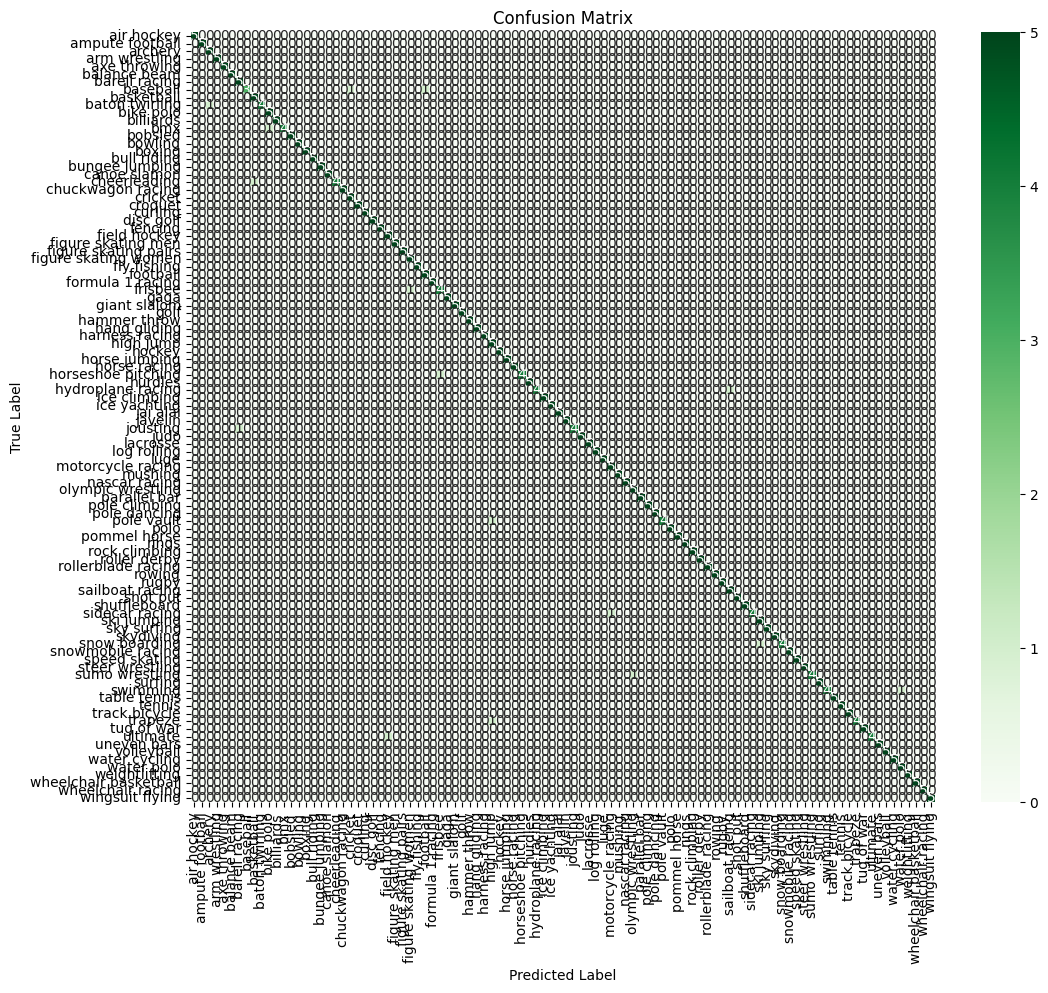

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_probs = model_efficient.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Report & confusion matrix
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**OBSERVATION**

- Overall accuracy is 0.97 and Precision, Recall and F1 accuracy is 0.97, near
  perfect performance in almost all categories.

- Zero class imbalance, each sport class is equally represented.

- Even difficult predictions Ski jumping Vs Snowboarding, Boxing Vs Wrestling
  are also accuratly predicted. A few classes had slightly low performance especially in baseball, cheerleading, frisbee and etc.,

- In confusion matrix, which is heavily diagonal and showing almost perfect    classifications and few off diagonal which shows misclassifications.

**SAVE AND EXPORT THE MODEL**

In [ ]:
model_efficient.save('/content/efficientnet_finetuned_model.h5')

In [ ]:
from google.colab import files
files.download("/content/efficientnet_finetuned_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TESTING THE MODEL WITH NEW UNSEEN IMAGES**

In [ ]:
# Upload an image to colab

from google.colab import files
uploaded = files.upload()

Saving Test_image_5.jpg to Test_image_5.jpg


In [ ]:
# Load and preprocess the image as same as model preprocessing during training
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from PIL import Image

In [ ]:
# Load image
img_path = list(uploaded.keys())[0]
img = Image.open(img_path).resize((224,224))   # Model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)   # EfficientNet preprocessing

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Capstone project 2- Sports image classification using transfer learning/efficientnet_finetuned_model.h5')

In [ ]:
# Model prediction
preds = model.predict(img_array)
predicted_class= np.argmax(preds, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [ ]:
# Example from training data
classes  = ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller derby', 'rollerblade racing', 'rowing', 'rugby', 'sailboat racing', 'shot put', 'shuffleboard', 'sidecar racing', 'ski jumping', 'sky surfing', 'skydiving', 'snow boarding', 'snowmobile racing', 'speed skating', 'steer wrestling', 'sumo wrestling', 'surfing', 'swimming', 'table tennis', 'tennis', 'track bicycle', 'trapeze', 'tug of war', 'ultimate', 'uneven bars', 'volleyball', 'water cycling', 'water polo', 'weightlifting', 'wheelchair basketball', 'wheelchair racing', 'wingsuit flying']
print("Predicted class:", classes[predicted_class])


Predicted class: volleyball


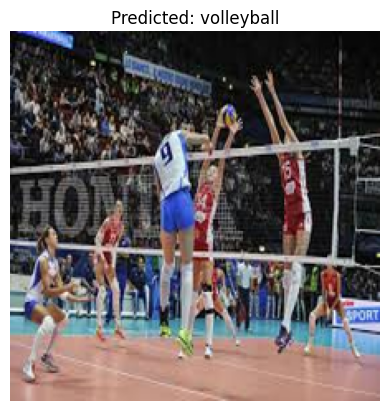

In [ ]:
# Display the image and prediction

import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {classes[predicted_class]}")
plt.show()


**PROJECT FINAL SUMMARY**

**Objective**

The goal of this capstone project was to build an accurate deep learning model capable of classifying images into 100 different sports categories. The following steps were performed:

**Data Preprocessing**

 Images were resized, normalized, and augmented to enhance generalization.

**Models evaluated**

- VGG16
- Inception
- Resnet
- EfficientNet


**Model Architecture**

A pretrained EfficientNetB0 model was used as the backbone for transfer learning, fine-tuned to adapt to the sports dataset.

**Training**

The model was trained with techniques like early stopping and learning rate scheduling to prevent overfitting and ensure convergence.

**Evaluation**

- Achieved a test accuracy of 96.8%, with a test loss of ~0.15.

- Classification metrics (precision, recall, and F1-score) were consistently high across all classes.

- The confusion matrix confirmed that misclassifications were minimal and the model generalized well.

**Deployment**

 The model was successfully tested on new unseen images from Google Drive, maintaining strong performance.


**Future improvements**

There are some ideas for future improvements

- Use more advanced Efficientnet models like B3, B5 and V2 for potentially better accuracy
- Deploy the model as a web or mobile app using streamlit & Flask and Android/ios integration
- Integrate webcam or live video input to classify sports in realtime.

**Github link**